# Time Series vs Supervised Learning

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import datetime
from pandas import Series
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Zadanie
Wczytaj dane "Monthly Car Sales Dataset", które pisują liczbę sprzedanych samochodów w Quebec, Kanada w latach 1960 i 1968.

In [2]:
series_row = Series.from_csv('./daily-minimum-temperatures.csv', header=0)
series_row.head()

C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\series.py:3727: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64

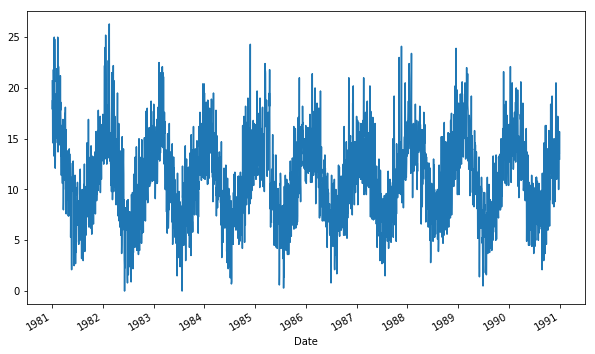

In [3]:
plt.figure(figsize=(10,6));
series_row.plot()
plt.show()

In [4]:
series_row_np = series_row.values
test_series = series_row.values[-1000:]
series = series_row.values[:-1000]

In [5]:
print(test_series.shape)
print(series.shape)

(1000,)
(2647,)


In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
df = pd.DataFrame()
df['t'] = [x for x in series]
dataframe = series_to_supervised(df, 15)
dataframe.head()

,var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
15,20.7,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,20.7
16,17.9,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,20.7,20.6
17,18.8,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,20.7,20.6,24.8
18,14.6,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,20.7,20.6,24.8,17.7
19,15.8,15.8,15.8,17.4,21.8,20.0,16.2,13.3,16.7,21.5,25.0,20.7,20.6,24.8,17.7,15.5


# Zadanie
Proszę wybrać optymalną metodę regresji do powyższych danych.

  * prosze podzielić zbiór danych na czść treningową i testową
  * proszę za pomoca cross validat-cji dobrać optymalne parametry
  * proszę wypisać zbiorcza tabelę z wynikami względem miar
    * explained_variance_score
    * mean_absolute_error
    * mean_squared_error
    * median_absolute_error
    * r2
  * Proszę użyć  
    * ElasticNet sklearn.linear_model.ElasticNet
    * Lasso sklearn.linear_model.Lasso
    * Ridge sklearn.linear_model.Ridge
    * LR sklearn.linear_model.LinearRegression
    * SVR sklearn.svm.SVR
    * RFR sklearn.ensemble.RandomForestRegressor
    * MLP_R sklearn.neural_network.MLPRegressor 

In [8]:
array = dataframe.values
# split into input and output
X = array[:,0:-1]
y = array[:,-1]

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [10]:
seed=123
from sklearn import model_selection
kfold = model_selection.KFold(n_splits=4, random_state=seed)

In [11]:
grid_1 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=1, tol=0.1)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'elasticnet__alpha': [1., 2., 3.]},
                    cv=kfold,
                    refit=True)
grid_1.fit(X_train, y_train)
print(grid_1.best_params_)
grid_1.best_estimator_


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

{'elasticnet__alpha': 1.0, 'polynomialfeatures__degree': 1}


Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.1, warm_start=False))])

In [12]:
grid_2 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=1, tol=0.1)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'lasso__alpha': [0.1, 1, 2, 3]},
                    cv=5,
                    refit=True)
grid_2.fit(X, y)
grid_2.best_params_

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

{'lasso__alpha': 0.1, 'polynomialfeatures__degree': 1}

In [13]:
grid_3 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1, tol=0.1)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4],
                    'ridge__alpha': [0.1, 1, 2, 3]},
                    cv=5,
                    refit=True)
grid_3.fit(X, y)
grid_3.best_params_

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=7.88861e-18): result may not be accurate.
  overwrite_a=False)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=7.68811e-18): result may not be accurate.
  overwrite_a=False)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=6.91662e-18): result may not be accurate.
  overwrite_a=False)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=6.90052e-18): result may not be accurate.
  overwrite_a=False)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:152: LinAlgWarning: Ill-conditioned matrix (rcond=6.6628e-18): result may not be accurate.
  overwrite_a=False)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.p

{'polynomialfeatures__degree': 1, 'ridge__alpha': 3}

In [14]:
grid_4 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3, 4]},
                    cv=kfold,
                    refit=True)
grid_4.fit(X, y)
print(grid_4.best_params_)
grid_4.best_estimator_

{'polynomialfeatures__degree': 1}


Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [15]:
from sklearn.svm import SVR
grid_5 = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                    param_grid={"C": [300, 400, 500, 1000, 1500, 2000], 
                                "gamma": [0.0000001, 0.000001, 0.00001, 0.0001]},
                    cv=kfold,
                    refit=True)
grid_5.fit(X, y)
print(grid_5.best_params_)
grid_5.best_estimator_

{'C': 300, 'gamma': 1e-05}


SVR(C=300, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-05,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [16]:
from sklearn.ensemble import RandomForestRegressor
param_grid = {
    'n_estimators': [70, 200, 700, 800],
    'max_depth':  [100, 170, 200],
    'max_features': ['log2','sqrt','auto'],
    'max_leaf_nodes':  [100, 200],
#     'min_impurity_decrease':  [0, 1, 2],
    
}
rfc = RandomForestRegressor(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 
grid_6 = GridSearchCV(estimator=rfc, 
                      param_grid=param_grid, 
                      cv= kfold)
grid_6.fit(X, y)
print(grid_6.best_params_)
grid_6.best_estimator_

{'max_depth': 170, 'max_features': 'auto', 'max_leaf_nodes': 100, 'n_estimators': 70}


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=170,
           max_features='auto', max_leaf_nodes=100,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [17]:
from sklearn.neural_network import MLPRegressor
grid_7 = GridSearchCV(MLPRegressor(hidden_layer_sizes=(100,100,100),activation='tanh',alpha=0.0001, max_iter=5000),#model powinien byc zainicjalizowany
                    param_grid={'hidden_layer_sizes': [(300, 200, 100, 10),(200,100,10)],
                               'activation': ['logistic', 'relu']                               
                               },#parametry do podstawienia
                    cv=kfold,#na ile czesci ma dzielic zbior
                    n_jobs=-1,
                    refit=True)
grid_7.fit(X_train, y_train)
print(grid_7.best_params_)
grid_7.best_estimator_

KeyboardInterrupt: 

In [18]:
from sklearn import  metrics


models = []
models.append(('ElasticNet', grid_1.best_estimator_))
models.append(('Lasso', grid_2.best_estimator_))
models.append(('Ridge', grid_3.best_estimator_))
models.append(('LR', grid_4.best_estimator_))
models.append(('SVR', grid_5.best_estimator_))
models.append(('RFR', grid_6.best_estimator_))
# models.append(('MLP_R', grid_7.best_estimator_))

r2 = []
explained_variance_score = []
median_absolute_error = []
mean_squared_error = []
mean_absolute_error = []
for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test)) ))
    print("Explained variance score: {}".format( metrics.explained_variance_score(y_test, model.predict(X_test)) ))
    print("Median absolute error: {}".format( metrics.median_absolute_error(y_test, model.predict(X_test)) ))
    print("Mean squared error: {}".format( metrics.mean_squared_error(y_test, model.predict(X_test)) ))
    print("Mean absolute errors: {}".format(metrics.mean_absolute_error(y_test, model.predict(X_test)) ))
    r2.append(metrics.r2_score(y_test, model.predict(X_test)))
    explained_variance_score.append(metrics.explained_variance_score(y_test, model.predict(X_test)))
    median_absolute_error.append( metrics.median_absolute_error(y_test, model.predict(X_test)))
    mean_squared_error.append(metrics.mean_squared_error(y_test, model.predict(X_test)))
    mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))

ElasticNet
R^2: 0.6352198400980078
Explained variance score: 0.6361711279393907
Median absolute error: 1.528538195050193
Mean squared error: 6.170172062242971
Mean absolute errors: 1.9199447521175579
Lasso
R^2: 0.658312050369938
Explained variance score: 0.65896824721325
Median absolute error: 1.4542927428293417
Mean squared error: 5.779572664749462
Mean absolute errors: 1.856854443016868
Ridge
R^2: 0.6578636827301547
Explained variance score: 0.6585362901498375
Median absolute error: 1.5035204592419689
Mean squared error: 5.787156699707251
Mean absolute errors: 1.8667809469823682
LR
R^2: 0.6578638888969817
Explained variance score: 0.6585366751220383
Median absolute error: 1.5040162410637485
Mean squared error: 5.787153212443042
Mean absolute errors: 1.8667977615090399
SVR
R^2: 0.6565355728328182
Explained variance score: 0.6566911357010721
Median absolute error: 1.4609151073419042
Mean squared error: 5.8096213715423
Mean absolute errors: 1.8557375569354584
RFR
R^2: 0.8070693323622615

In [19]:
import pandas as pd
d = {'r2': r2, 
     'explained_variance_score': explained_variance_score, 
     'median_absolute_error': median_absolute_error,
     'mean_squared_error' : mean_squared_error,
     'mean_absolute_error' : mean_absolute_error,
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['ElasticNet','Lasso','Ridge','LR','SVR', 'RF'])#,'MLP_R'])
df

,Method,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
0,ElasticNet,0.635220,0.636171,1.528538,6.170172,1.919945
1,Lasso,0.658312,0.658968,1.454293,5.779573,1.856854
2,Ridge,0.657864,0.658536,1.503520,5.787157,1.866781
3,LR,0.657864,0.658537,1.504016,5.787153,1.866798
4,SVR,0.656536,0.656691,1.460915,5.809621,1.855738
5,RF,0.807069,0.807409,1.124162,3.263378,1.414440


In [20]:
train = series
test = test_series
series_row.shape[0]

3647

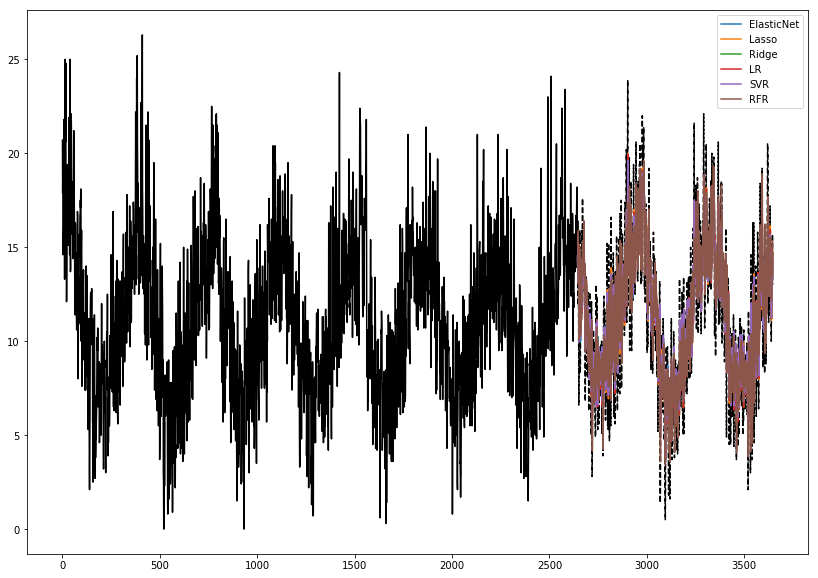

In [21]:
size=15

plt.figure(figsize=(14,10))
plt.plot(series,'k-')
data = np.zeros(series_row_np.shape[0], dtype=float)
data.fill(np.nan)
data[-1001:] = series_row.values[-1001:]
plt.plot(data, 'k--')

all_data = []
for name, model in models: 
    data = np.zeros(series_row_np.shape[0], dtype=float)
    data.fill(np.nan)
    for i in range(1,1000):
        point = np.array([series_row_np[ (series_row_np.shape[0]-((size+1*i))):(series_row_np.shape[0]-(1*i))]])
        pre=model.predict(point)
        
        data[-i]=pre
    all_data.append(data)
    plt.plot( data , label=name)
    plt.legend(loc='best')
plt.show()